In [22]:
from matplotlib import pyplot as plt
from windrose import WindroseAxes
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from utils.data import get_data
from utils.model_eval import mean_absolute_percentage_error
import os, numpy as np, seaborn as sns, pandas as pd

In [2]:
data = get_data()

In [25]:
data = data.drop([i for i in range(720)], axis = 1)

In [5]:
def plotAllScatterFVFg(dirpath = './data/parts/'):
    files = [dirpath + file for file in os.listdir(dirpath) if file.endswith('.feather')]

    for file in files:
        data = pd.read_feather(file)
        data = data[data.f < data.fg]
        data = data[data.fg <= 75]
        plt.scatter(data.f, data.fg, s = 0.1, c = 'grey', marker = 'x')

    plt.xlabel('f')
    plt.ylabel('fg')
    plt.show()

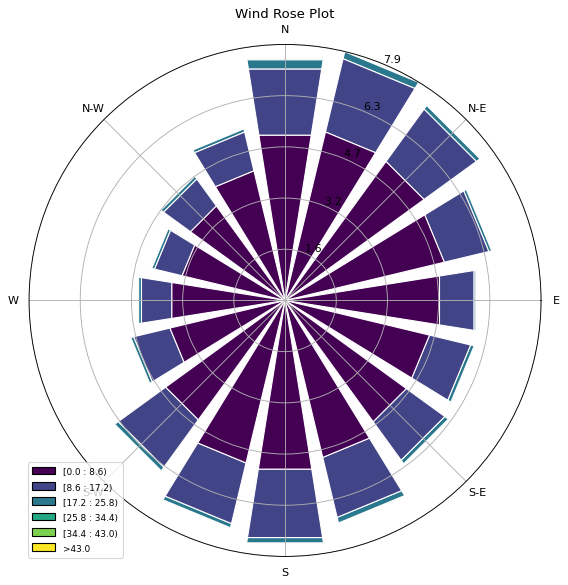

In [4]:
# Plot wind rose
ax = WindroseAxes.from_ax()
ax.bar(data.d, data.f, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Wind Rose Plot')
plt.show()

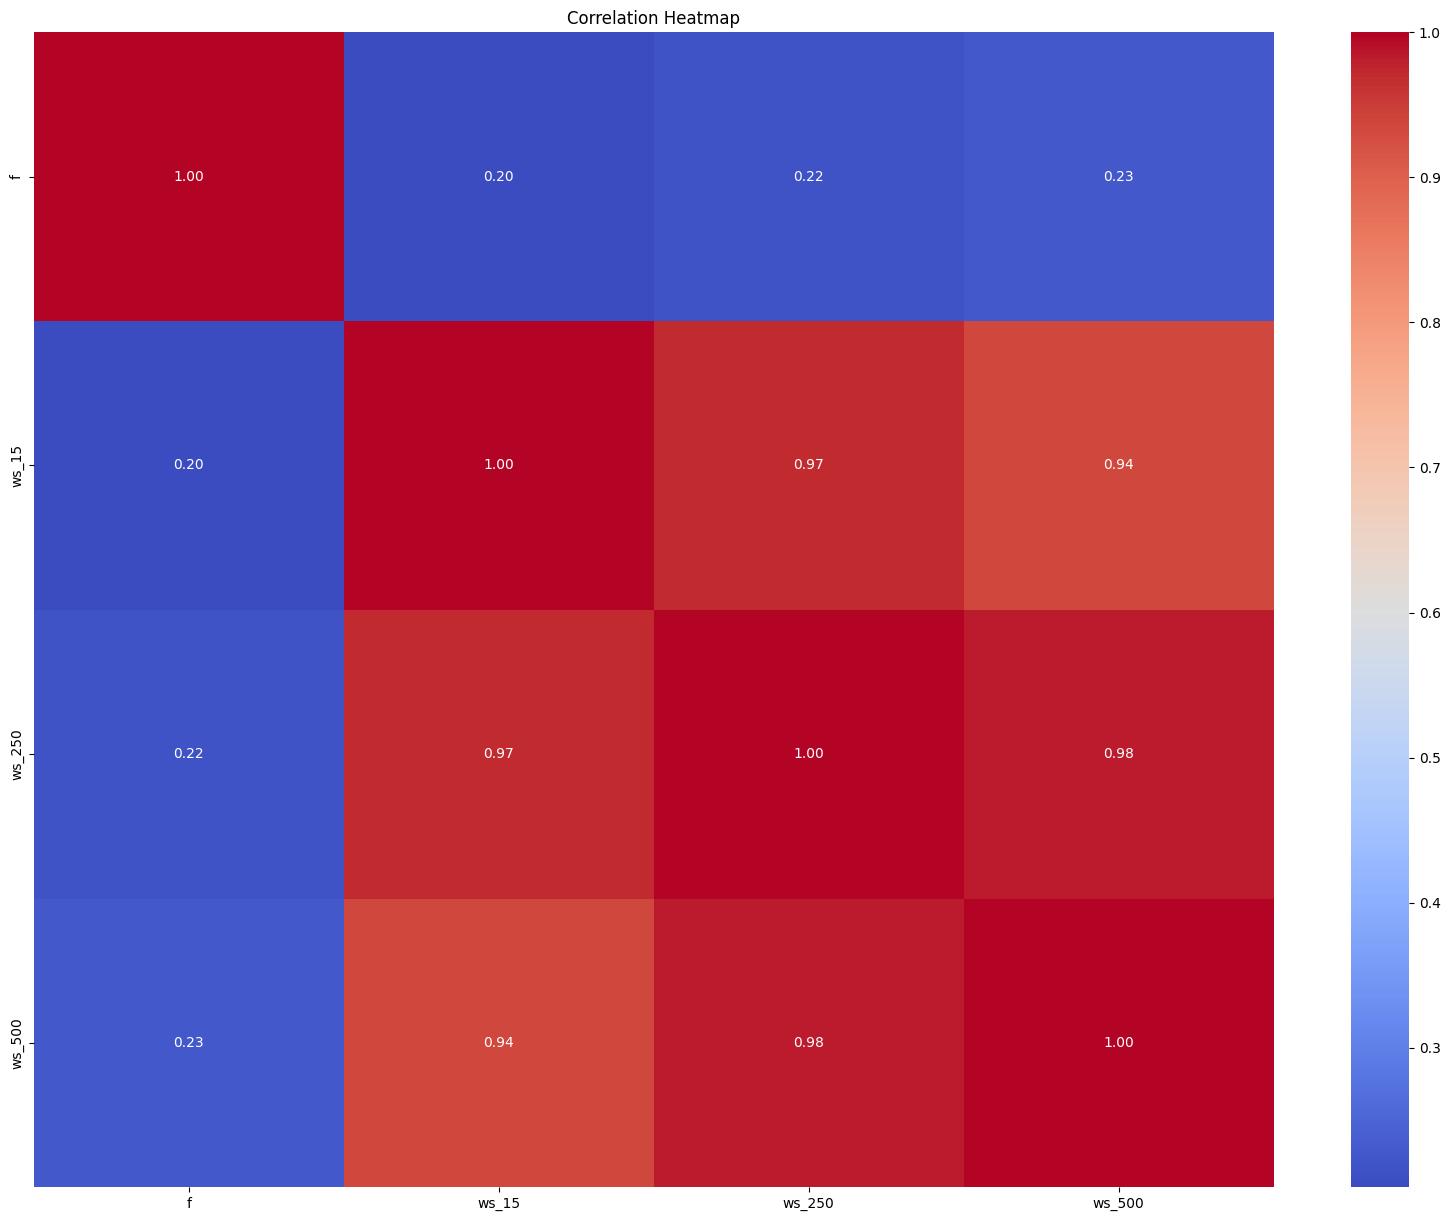

In [5]:
import seaborn as sns
correlation_matrix = data[['f', 'ws_15', 'ws_250', 'ws_500']].corr()
# Plot correlation heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

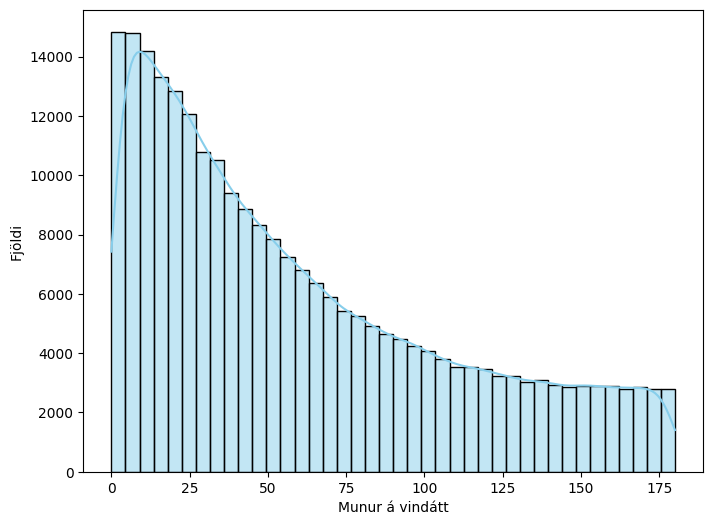

In [6]:
# Calculate the difference in wind direction between reanalysis and measured data
wind_direction_difference = data['wd_15'] - data['d']

# Remove potential wrap-around (e.g., if wind direction is 350 degrees and 10 degrees)
wind_direction_difference = np.where(wind_direction_difference > 180, wind_direction_difference - 360, wind_direction_difference)
wind_direction_difference = np.where(wind_direction_difference < -180, wind_direction_difference + 360, wind_direction_difference)

wind_direction_difference = abs(wind_direction_difference)

# Plot histogram of wind direction difference
plt.figure(figsize=(8, 6))
sns.histplot(wind_direction_difference, bins=40, kde=True, color='skyblue', edgecolor='black')
plt.xlabel('Munur á vindátt')
plt.ylabel('Fjöldi')
#plt.savefig('./data/figures/wind_direction_difference.png')
plt.show()


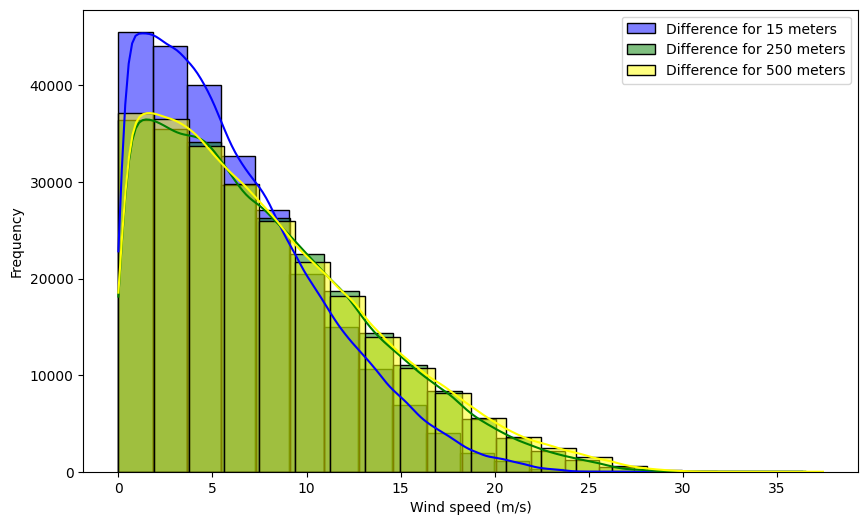

In [12]:
# Plot histograms of wind speed from measurement and reanalysis data
plt.figure(figsize=(10, 6))
diff_15 = abs(data.f - data.ws_15)
diff_250 = abs(data.f - data.ws_250)
diff_500 = abs(data.f - data.ws_500)
sns.histplot(diff_15, bins=20, kde=True, color='blue', label='Difference for 15 meters')
sns.histplot(diff_250, bins=20, kde=True, color='green', label='Difference for 250 meters')
sns.histplot(diff_500, bins=20, kde=True, color='yellow', label='Difference for 500 meters')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Frequency')
plt.legend()
#plt.savefig('./data/figures/wind_speed_difference_each_en.png')
plt.show()

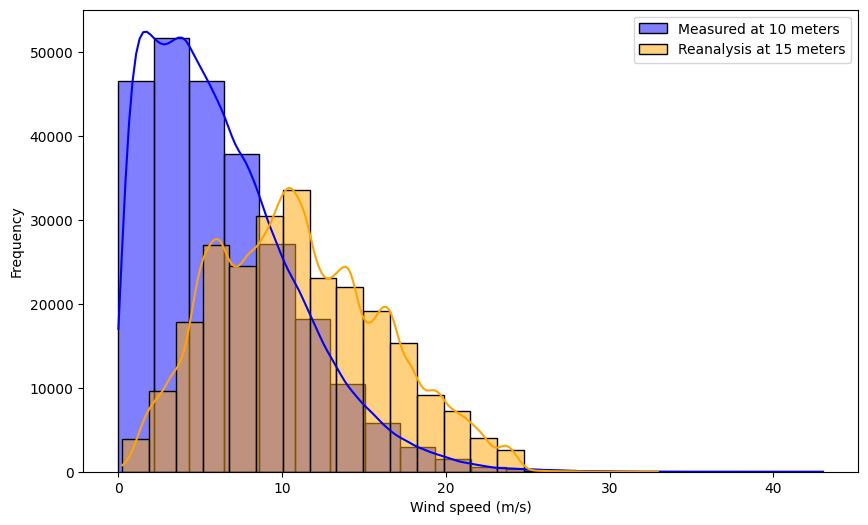

In [13]:
# Plot histograms of wind speed from measurement and reanalysis data
plt.figure(figsize=(10, 6))
sns.histplot(data.f, bins=20, kde=True, color='blue', label='Measured at 10 meters')
sns.histplot(data.ws_15, bins=20, kde=True, color='orange', label='Reanalysis at 15 meters')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Frequency')
plt.legend()
#plt.savefig('./data/figures/wind_speed_difference_en.png')
plt.show()

In [14]:
data[data.stod == 1350]

,time,stod,f,fg,d,lon,lat,X,Y,ws_15,...,710,711,712,713,714,715,716,717,718,719
0,2005-02-10 03:00:00,1350,4.17,5.29,344.4,-22.6005,63.9829,323796.3996,391631.6311,2.5767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2005-02-10 06:00:00,1350,7.78,10.42,321.8,-22.6005,63.9829,323796.3996,391631.6311,10.5878,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2005-02-10 09:00:00,1350,5.27,7.22,333.2,-22.6005,63.9829,323796.3996,391631.6311,11.6747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2005-02-10 12:00:00,1350,3.00,4.73,209.2,-22.6005,63.9829,323796.3996,391631.6311,8.0040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2005-02-10 18:00:00,1350,12.80,19.86,274.1,-22.6005,63.9829,323796.3996,391631.6311,12.3872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,2006-02-28 09:00:00,1350,6.24,9.47,27.0,-22.6005,63.9829,323796.3996,391631.6311,6.9246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2566,2006-02-28 12:00:00,1350,10.74,15.29,37.7,-22.6005,63.9829,323796.3996,391631.6311,5.3428,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2567,2006-02-28 15:00:00,1350,7.22,11.99,43.2,-22.6005,63.9829,323796.3996,391631.6311,3.2651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2568,2006-02-28 18:00:00,1350,6.91,11.34,59.5,-22.6005,63.9829,323796.3996,391631.6311,1.1989,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
abDiff = np.abs(data.f - data.ws_15)
skew = 3*(np.mean(abDiff) - np.median(abDiff))/np.std(abDiff)

skew

0.6181979907624712

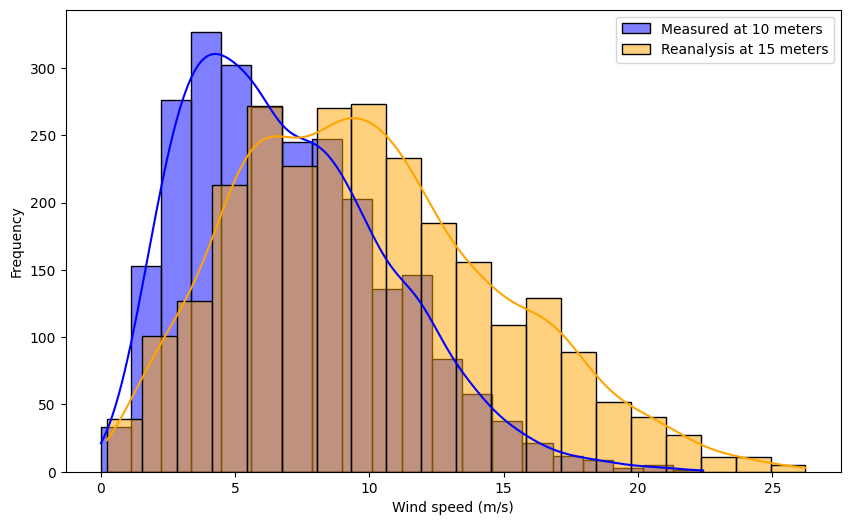

In [24]:
# Plot histograms of wind speed from measurement and reanalysis data
plt.figure(figsize=(10, 6))
sns.histplot(data[data.stod == 1350].f, bins=20, kde=True, color='blue', label='Measured at 10 meters')
sns.histplot(data[data.stod == 1350].ws_15, bins=20, kde=True, color='orange', label='Reanalysis at 15 meters')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Frequency')
plt.legend()
#plt.savefig('./data/figures/wind_speed_difference_en.png')
plt.show()